In [1]:
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import copy
import math

from Models.Caller64 import *
from Utilities.Utilities import ReadYaml, SerializeObjects, DeserializeObjects, LoadModelConfigs, LoadParams
from Utilities.Visualization import VisReconGivenZ_FCA, HeatMapFreqZ_FCA, VisReconGivenFC_ZA, VisReconExtractZ_FC
from tqdm import trange, tqdm
import itertools
from scipy.stats import mode


## GPU selection
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#tf.config.set_visible_devices([], 'GPU')



In [2]:
YamlPath = './Config/EvalConfigMimic.yml'
ModelConfigs = ReadYaml(YamlPath)
[i for i in ModelConfigs]

['Common_Info', 'Parameters']

In [3]:
def SamplingZ (Data, SampModel, NMiniBat, NParts, NSubGen, BatchSize = 1000, GPU=True, SampZType='Modelbd',  SecDataType=None, ReparaStdZj=1.):
    
    '''
    Sampling Samp_Z 
    - Return shape of Samp_Z: (NMiniBat, NGen, LatDim) -> (NMiniBat*NGen, LatDim) for optimal use of GPU 
    - NGen = NParts * NSubGen
    
    - Modelbd: The predicted values are repeated NGen times after the prediction. 
    - Modelbr: The data is repeated NParts times before the prediction. Then, The predicted values are repeated NSubGen times.
    - Gaussbr: The data sampled (NMiniBat, NParts, LatDim) from the Gaussian distribution is repeated NSubGen times. 
    '''
    
    assert SampZType in ['Modelbd','Modelbdr', 'Gaussbr'], "Please verify the value of 'SampZType'. Only 'Modelbd','Modelbdr', and 'Gaussbr' are valid."
    NGen = NParts * NSubGen
    
    # Sampling Samp_Z
    if SampZType =='Modelbd': # Z ~ N(Zμ|y, σ) or N(Zμ|y, cond, σ) 
        # Shape of UniqSamp_Z: (NMiniBat, LatDim) 
        UniqSamp_Z = Sampler(Data, SampModel, BatchSize=BatchSize, GPU=GPU)
        Samp_Z =  np.broadcast_to(UniqSamp_Z[:, None], (NMiniBat, NGen, UniqSamp_Z.shape[-1])).reshape(-1, UniqSamp_Z.shape[-1])
    
    elif SampZType =='Modelbdr':
        DataExt = np.repeat(Data, NParts, axis=0)
        # Shape of UniqSamp_Z: (NMiniBat, NParts, LatDim) 
        UniqSamp_Z = Sampler(DataExt, SampModel, BatchSize=BatchSize, GPU=GPU).reshape(NMiniBat, NParts, -1)
        Samp_Z =  np.broadcast_to(UniqSamp_Z[:, :, None], (NMiniBat, NParts, NSubGen, UniqSamp_Z.shape[-1])).reshape(-1, UniqSamp_Z.shape[-1])
    
    elif SampZType =='Gaussbr': # Z ~ N(0, ReparaStdZj)
        # Shape of UniqSamp_Z: (NMiniBat, NParts, LatDim) 
        UniqSamp_Z = np.random.normal(0, ReparaStdZj, (NMiniBat, NParts , SampModel.output.shape[-1]))
        Samp_Z =  np.broadcast_to(UniqSamp_Z[:, :, None], (NMiniBat, NParts, NSubGen, UniqSamp_Z.shape[-1])).reshape(-1, UniqSamp_Z.shape[-1])

    # Return shape of Samp_Z: (NMiniBat*NParts*NSubGen, LatDim)
    return Samp_Z


def SamplingZj (Samp_Z, NMiniBat,  NParts, NSubGen, LatDim, NSelZ, ZjType='bd' ):
    
    '''
     Sampling Samp_Zj 
    - Return shape of Samp_Zj: (NMiniBat, NGen, LatDim) -> (NMiniBat*NGen, LatDim) for optimal use of GPU 
    - Masking is applied to select Samp_Zj from Samp_Z 
      by assuming that the Samp_Z with indices other than j have a fixed mean value of '0' following a Gaussian distribution.
    - Samp_Zj ~ N(Zμj|y, σj), j∼U(1,LatDim)
    - In the expression j∼U(1,LatDim), j corresponds to LatDim and all js are selected randomly.
    '''
    NGen = NParts * NSubGen
    
    # Masking for selecting Samp_Zj from Samp_Z 
    if ZjType =='bd': 
        Mask_Z = np.zeros((NMiniBat, NGen, LatDim))
        for i in range(NMiniBat):
            Mask_Z[i, :, np.random.choice(LatDim, NSelZ,replace=False )] = 1
    
    # Selecting Samp_Zj from Samp_Z 
    Mask_Z = Mask_Z.reshape(NMiniBat*NGen, LatDim)
    Samp_Zj = Samp_Z * Mask_Z

    # Return shape of Samp_Zj: (NMiniBat*NGen, LatDim)
    return Samp_Zj


def SamplingFCs (Data, SampModel, NMiniBat, NParts, NSubGen, BatchSize = 1000, GPU=True, SampFCType='Modelbdrm', FcLimit= 0.05):

    # Check for valid SampFCType values
    assert SampFCType in ['Modelbdrm', 'Modelbdm'], "Please verify the value of 'SampFCType'. Only 'Modelbdrm', and 'Modelbdm' are valid."
    
    # Sampling FCs
    if SampFCType =='Modelbdrm':
        DataExt = np.repeat(Data, NParts*NSubGen, axis=0)
        ## Return shape of Samp_FC: (NMiniBat*NParts*NSubGen, NFCs) for optimal use of GPU
        Samp_FC = Sampler(DataExt, SampModel, BatchSize=BatchSize, GPU=GPU).reshape(-1, SampModel.output.shape[-1])

    elif SampFCType =='Modelbdm':
        DataExt = np.repeat(Data, NSubGen, axis=0)
        # Shape of UniqSamp_FC: (NMiniBat, 1, NSubGen, LatDim) 
        UniqSamp_FC = Sampler(DataExt, SampModel, BatchSize=BatchSize, GPU=GPU).reshape(NMiniBat, 1, NSubGen, -1)
        Samp_FC =  np.broadcast_to(UniqSamp_FC, (NMiniBat, NParts, NSubGen, UniqSamp_FC.shape[-1])).reshape(-1, UniqSamp_FC.shape[-1])

    # Return shape of Samp_FC: (NMiniBat*NParts*NSubGen, LatDim)
    return Samp_FC * FcLimit


# Power spectral density 
def FFT_PSD (Data, ReducedAxis, MinFreq = 1, MaxFreq = 51):
    # Dimension check; this part operates with 3D tensors.
    # (NMiniBat, NGen, SigDim)
    Data = Data[:,None] if len(Data.shape) < 3 else Data

    # Power Spectral Density
    HalfLen = Data.shape[-1]//2
    FFTRes = np.abs(np.fft.fft(Data, axis=-1)[..., :HalfLen])[..., MinFreq:MaxFreq]
    # (NMiniBat, NGen, N_frequency)
    PSD = (FFTRes**2)/Data.shape[-1]

    # Probability Density Function
    if ReducedAxis == 'All':
        AggPSD = np.mean(PSD, axis=(0,1))
        # (N_frequency,)
        AggPSPDF = AggPSD / np.sum(AggPSD, axis=(-1),keepdims=True)
    elif ReducedAxis == 'None':
        # (NMiniBat, NGen, N_frequency)
        AggPSPDF = PSD / np.sum(PSD, axis=(-1),keepdims=True)    
        
    return AggPSPDF




# Permutation given PSD over each generation
def ProbPermutation(Data, WindowSize=3):
    # To make the data have the shape: (NMiniBat, N_frequency, NGen)
    Data = np.transpose(Data, (0,2,1))
    
    # For the M generation vectors, Data shape: (NMiniBat, N_frequency, NGen)
    # For the true PSD, Data shape: (1, N_frequency, NMiniBat)
    
    # Generating true permutation cases
    TruePerms = np.concatenate(list(itertools.permutations(np.arange(WindowSize)))).reshape(-1, WindowSize)

    # Getting all permutation cases
    Data_Ext = tf.signal.frame(Data, frame_length=WindowSize, frame_step=1, axis=-1)
    PermsTable =  np.argsort(Data_Ext, axis=-1)

    CountPerms = 1- (TruePerms[None,None,None] == PermsTable[:,:,:, None])
    CountPerms = 1-np.sum(CountPerms, axis=-1).astype('bool')

    # Reducing the window axis
    CountPerms = np.sum(CountPerms, axis=(2))
    
    # Data shape: (NMiniBat, N_frequency, N_permutation_cases)
    ProbCountPerms = CountPerms / np.sum(CountPerms, axis=(1,2), keepdims=True)
    
    return np.maximum(ProbCountPerms, 1e-7) 
    


def GenBatches(data_list, batch_size):
    max_length = len(data_list[0])
    for i in range(0, max_length, batch_size):
        yield [data[i:i + batch_size] for data in data_list]

#The 'predict' function in TensorFlow version 2.10 may cause memory leak issues.
def CompResource (PredModel, Data, BatchSize=1, GPU=True):  # GPU vs CPU

    if GPU==False:
        with tf.device('/CPU:0'):
            PredVal = PredModel.predict(Data, batch_size=BatchSize, verbose=1)
    else:
        PredVal = PredModel.predict(Data, batch_size=BatchSize, verbose=1)

    return PredVal



# For the dimensional Kullback-Leibler Divergence of the Z distribution
def LogNormalDensity(LatSamp, LatMean, LogSquaScale):
    Norm = tf.math.log(2. * tf.constant(np.pi))
    InvSigma = tf.math.exp(-LogSquaScale)
    MeanSampDiff = (LatSamp - LatMean)
    return -0.5 * (MeanSampDiff * MeanSampDiff * InvSigma + LogSquaScale + Norm)


# For Factor-VAE
def SplitBatch (Vec, HalfBatchIdx1, HalfBatchIdx2, mode='Both'):
    
    HalfBatch1 = tf.nn.embedding_lookup(Vec, HalfBatchIdx1)
    HalfBatch2 = tf.nn.embedding_lookup(Vec, HalfBatchIdx2)
    
    if mode=='Both':
        return  HalfBatch1, HalfBatch2
    elif mode=='D1':
        return  HalfBatch1
    elif mode=='D2':
        return  HalfBatch2
    


def MeanKLD(P,Q):
    return np.mean(np.sum(P*np.log(P/Q), axis=-1))



# The 'predict' function in TensorFlow version 2.10 may cause memory leak issues.
def Sampler (Data, SampModel,BatchSize=100, GPU=True):
    if GPU==False:
        with tf.device('/CPU:0'):
            PredVal = SampModel.predict(Data, batch_size=BatchSize, verbose=1)   
    else:
        PredVal = SampModel.predict(Data, batch_size=BatchSize, verbose=1)   

    return PredVal


def Partition3D(Mat, NParts):
    B, M, F = Mat.shape
    PartSize = M // NParts
    Remainder = M % NParts

    NewMat = np.zeros_like(Mat)
    # ReturnIDX will store the partition ID and local position for each element
    ReturnIDX = np.zeros((B, M, 2), dtype=int)  # Adding an extra dimension for partition ID and local position

    for b in range(B):
        CumulativeIndex = 0
        for i in range(NParts):
            PartSizeAdjusted = PartSize + (1 if i < Remainder else 0)
            Slice = Mat[b, CumulativeIndex:CumulativeIndex + PartSizeAdjusted, :]
            SortedIndices = np.argsort(Slice, axis=0)
            SortedSlice = np.take_along_axis(Slice, SortedIndices, axis=0)

            NewMat[b, CumulativeIndex:CumulativeIndex + PartSizeAdjusted, :] = SortedSlice
            # Store partition ID and local position
            ReturnIDX[b, CumulativeIndex:CumulativeIndex + PartSizeAdjusted, 0] = i
            for f in range(F):
                ReturnIDX[b, CumulativeIndex:CumulativeIndex + PartSizeAdjusted, 1] = np.arange(PartSizeAdjusted)

            CumulativeIndex += PartSizeAdjusted

    return NewMat, ReturnIDX[:,:,0]


def GenConArange (ConData, NGen):
    # Processing Conditional information 
    ## Finding the column index of the max value in each row of ConData and sort the indices
    ArgMaxP_PSPDF = np.argmax(ConData, axis=-1)
    SortIDX = np.column_stack((np.argsort(ArgMaxP_PSPDF), ArgMaxP_PSPDF[np.argsort(ArgMaxP_PSPDF)]))

    # Computing the number of iterations
    UniqPSPDF = np.unique(ArgMaxP_PSPDF)
    NIter = NGen // len(UniqPSPDF)

    # Selecting one row index for each unique value, repeated for NIter times and ensure the total number of selected indices matches NGen
    SelIDX = np.concatenate([np.random.permutation(SortIDX[SortIDX[:, 1] == psd])[:1] for psd in UniqPSPDF for _ in range(NIter)], axis=0)
    SelIDX = np.vstack((SelIDX, np.random.permutation(SortIDX)[:NGen - len(SelIDX)]))

    # Sorting IDX based on the max values
    SelIDX = SelIDX[np.argsort(SelIDX[:, 1])]

    ## Generating CON_Arange
    return ConData[SelIDX[:,0]]


def GenConArangeSimple (ConData, NGen, seed=1):

    ### Selecting Conditional dataset randomly
    np.random.seed(seed)
    ConData = np.random.permutation(ConData)[:NGen]
    
    ### Identifying the index of maximum frequency for each selected condition
    MaxFreqSelCond = np.argmax(ConData, axis=-1)
    ### Sorting the selected conditions by their maximum frequency
    Idx_MaxFreqSelCond = np.argsort(MaxFreqSelCond)
    CONbm_Sort = ConData[Idx_MaxFreqSelCond]

    return CONbm_Sort



def Denorm (NormX, MaxX, MinX):
    return NormX * (MaxX - MinX) + MinX 


def MAPECal (TrueData, PredSigRec, MaxX, MinX):
    # Denormalization
    DenormTrueData = Denorm(TrueData, MaxX, MinX).copy()
    DenormPredSigRec = Denorm(PredSigRec, MaxX, MinX).copy()
   
    # MAPE
    MAPEdenorm = np.mean(np.abs((DenormTrueData - DenormPredSigRec) / DenormTrueData)) * 100
    MAPEnorm = np.mean(np.abs(((TrueData+1e-7) - PredSigRec) / (TrueData+1e-7))) * 100

    return MAPEnorm, MAPEdenorm


def MSECal (TrueData, PredSigRec, MaxX, MinX):
    # Denormalization
    DenormTrueData = Denorm(TrueData, MaxX, MinX).copy()
    DenormPredSigRec = Denorm(PredSigRec, MaxX, MinX).copy()
   
    # MAPE
    MSEdenorm = np.mean((DenormTrueData - DenormPredSigRec)**2)
    MSEnorm = np.mean((TrueData - PredSigRec)**2)
    
    return MSEnorm, MSEdenorm


In [4]:
class Evaluator ():
    
    def __init__ (self, MinFreq=1, MaxFreq=51,  SimSize = 1, NMiniBat=100,  NSubGen=100, NParts=5, ReparaStdZj = 1, NSelZ = 1, 
                  SampBatchSize = 1000, GenBatchSize = 1000, SelMetricCut = 1., SelMetricType = 'KLD', GPU=False, Name=None):

        
        # Optional parameters with default values
        self.MinFreq = MinFreq               # The minimum frequency value within the analysis range (default = 1).
        self.MaxFreq = MaxFreq               # The maximum frequency value within the analysis range (default = 51).
        self.SimSize = SimSize               # Then umber of simulation repetitions for aggregating metrics (default: 1)
        self.NMiniBat = NMiniBat             # The size of the mini-batch, splitting the task into N pieces of size NMiniBat.
        self.NSubGen = NSubGen                 # The number of generations (i.e., samplings) within a sample.
        self.NParts = NParts                 # The number of partitions (i.e., samplings) in generations within a sample.
        self.ReparaStdZj = ReparaStdZj       # The size of the standard deviation when sampling Zj (Samp_Zjb ~ N(0, ReparaStdZj)).
        self.NSelZ = NSelZ                   # The size of js to be selected at the same time (default: 1).
        self.SampBatchSize = SampBatchSize   # The batch size during prediction of the sampling model.
        self.GenBatchSize= GenBatchSize      # The batch size during prediction of the generation model.
        self.GPU = GPU                       # GPU vs CPU during model predictions (i.e., for SampModel and GenModel). "The CPU is strongly recommended for optimal precision."
        self.SelMetricCut = SelMetricCut     # The threshold for Zs and ancillary data where the metric value is below SelMetricCut.
        self.SelMetricType = SelMetricType   # The type of metric used for selecting Zs and ancillary data. 
        self.Name = Name                     # Model name.
        self.NGen = NSubGen * NParts          # The number of generations (i.e., samplings) within the mini-batch.
    
    
    ''' ------------------------------------------------------ Ancillary Functions ------------------------------------------------------'''

    ### ----------- Searching for candidate Zj for plausible signal generation ----------- ###
    def LocCandZsMaxFreq (self, CandQV, Samp_Z, SecData=None):
        # Shape of CandQV: (NMiniBat, N_frequency, NGen)
        # Shape of Samp_Z: (NMiniBat x NGen, LatDim)
        # Shape of SecData: (NMiniBat x NGen, SecDataDim)

        
        if self.SelMetricType == 'Entropy': 
            # Calculating the entropies given the probability density function of the power spectral.
            ## Return shape: (NMiniBat x NGen )
            Score = -np.sum(CandQV * np.log(CandQV), axis=1).ravel()
    
        elif self.SelMetricType == 'KLD':
            # Calculating KLD(QV_Batch||CandQV_T) (KLD_BatGen) and selecing IDs for which KLD_BatGen less than SelMetricCut.
            ## Shape of CandQV_T: (NMiniBat, N_frequency, NGen) -> (NMiniBat x NGen, N_frequency, 1), Shape of QV_Batch: (1, N_frequency, NMiniBat)
            CandQV_T = CandQV.transpose(0,2,1).reshape(self.NMiniBat*self.NGen, -1)[:,:,None]
            KLD_BatGen = np.sum(self.QV_Batch * np.log(self.QV_Batch / CandQV_T ), axis=1)
        
            ## Return shape: (NMiniBat x NGen )
            Score = np.min(KLD_BatGen, axis=-1)

        
        # Getting the maximum frequency given the PSD from CandQV.
        ## The 0 frequency is excluded as it represents the constant term; by adding 1 to the index, the frequency and index can be aligned to be the same.
        ## Return shape: (NMiniBat, NGen) -> (NMiniBat x NGen) for the computational efficiency (i.e, ravel function applied)
        MaxFreq = np.argmax(CandQV, axis=1).ravel() + 1

        for Freq, _ in self.BestZsMetrics.items():
            FreqIdx = np.where(MaxFreq == Freq)[0]

            # Skipping the remainder of the code if there are no FreqIdx present at the predefined frequencies.
            if len(FreqIdx) <1: 
                continue;

            # Calculating the minimum of Score and selecting candidate Z-values(CandZs)
            MinScoreIdx = np.argmin(Score[FreqIdx]) 
            MinScore = np.min(Score[FreqIdx]) 
            CandZs = Samp_Z[[FreqIdx[MinScoreIdx]]]
            
            # Tracking results
            self.TrackerCand_Temp[Freq]['TrackZs'].append(CandZs[None])
            self.TrackerCand_Temp[Freq]['TrackMetrics'].append(MinScore[None])
            
            if SecData is not None: # for processing secondary data (SecData).
                CandSecData = SecData[[FreqIdx[MinScoreIdx]]]
                self.TrackerCand_Temp[Freq]['TrackSecData'].append(CandSecData[None])
            else:
                CandSecData = None

            # Updating the Min_SumH value if the current iteration value is smaller.
            if MinScore < self.BestZsMetrics[Freq][0]:
                self.BestZsMetrics[Freq] = [MinScore, CandZs, CandSecData]
                print('Candidate Z updated! ', 'Freq:', Freq, ', Score:', np.round(MinScore, 4))


    
    ### ------------------------  # Selecting nested Z values and secondary data matrix --------------------- ###
    def SubNestedZFix(self, SubTrackerCand):
                
        ''' Constructing the dictionary: {'KeyID': { 'TrackZs' : Zs, 'TrackSecData' : Secondary-data }}
           
           - Outer Dictionary:
             - Key (KeyID): A unique, sequentially increasing integer from 'Cnt'; That is, the sequence number in each frequency domain.
             - Value: An inner dictionary (explained below)
        
           - Inner Dictionary:
             - Key (TrackZs) : Value (Tracked Z-value matrix)
             - Key (TrackSecData) : Values (Tracked secondary data matrix)
        '''
        
        Cnt = itertools.count()
        if self.SecDataType == False:
            Results = {next(Cnt):{ 'TrackZs' : TrackZs} 
                        for TrackZs, TrackMetrics 
                        in zip(SubTrackerCand['TrackZs'], SubTrackerCand['TrackMetrics'])
                        if TrackMetrics < self.SelMetricCut }

        else:
            Results = {next(Cnt):{ 'TrackZs' : TrackZs, 'TrackSecData' : TrackSecData} 
                        for TrackZs, TrackSecData, TrackMetrics 
                        in zip(SubTrackerCand['TrackZs'], SubTrackerCand['TrackSecData'], SubTrackerCand['TrackMetrics'])
                        if TrackMetrics < self.SelMetricCut }
            
        return Results
    
    
    
    ### ------------------------------ Conducting task iteration ------------------------------ ###
    def Iteration (self, TaskLogic):

        # Just functional code for setting the initial position of the progress bar 
        self.StartBarPoint = self.TotalIterSize*(self.iter/self.TotalIterSize) 
        with trange(self.iter, self.TotalIterSize , initial=self.StartBarPoint, leave=False) as t:

            for sim in range(self.sim, self.SimSize):
                self.sim = sim

                # Check the types of ancillary data fed into the sampler model and define the pipeline accordingly.
                if self.SecDataType == 'CONDIN' : 
                    SplitData = [np.array_split(sub, self.SubIterSize) for sub in (self.AnalSig, self.TrueCond)] 

                else: # For models with a single input such as VAE and TCVAE.
                    SplitData = np.array_split(self.AnalSig, self.SubIterSize)    

                for mini in range(self.mini, self.SubIterSize):
                    self.mini = mini
                    self.iter += 1
                    print()

                    # Core part; the task logic as the function
                    if self.SecDataType  == 'CONDIN': 
                        TaskLogic([subs[mini] for subs in SplitData])
                    else:
                        TaskLogic(SplitData[mini])

                    t.update(1)
    
    
    
    ### ------------------- Selecting post-sampled Z values for generating plausible signals ------------------- ###
    def SelPostSamp (self, SelMetricCut=np.inf, BestZsMetrics=None, TrackerCand=None, SavePath=None ):
        
        ## Optional parameters
        # Updating The threshold value for selecting Zs in SubNestedZFix if needed.
        self.SelMetricCut = SelMetricCut

        # Setting arguments
        BestZsMetrics = self.BestZsMetrics if BestZsMetrics is None else BestZsMetrics
        TrackerCand = self.TrackerCand if TrackerCand is None else TrackerCand
                
        # Exploring FreqIDs available for signal generation  
        ## FreqIDs such as [9, 10, 11 ..... 45]
        ## item[0] contains frequency domains
        ## item[1][0] contains metrics
        self.CandFreqIDs = [item[0] for item in BestZsMetrics.items() if item[1][0] != np.inf ]
            
        
        # Selecting nested Z values and secondary data matrix
        '''  Constructing the dictionary : {'FreqID' : {'SubKeys' : { 'TrackZs' : Zs, 'TrackSecData' : Secondary-data }}}
        
           - Outermost Dictionary:
             - Key (FreqID): Represents frequency identifiers.
             - Value: A second-level dictionary (explained below).
        
           - Second-level Dictionary:
             - Key (SubKeys): Represents sub-key (i.e., ID) for the given 'FreqID'.
             - Value: A third-level dictionary (explained below).
        
           - Third-level Dictionary:
             - Key (TrackZs) : Value (Tracked Z-value matrix)
             - Key (TrackSecData) : Values (Tracked secondary data matrix)
             
        '''
        self.PostSamp = {FreqID : self.SubNestedZFix(TrackerCand[FreqID], ) for FreqID in self.CandFreqIDs}

        
        
        # Counting the number of obs in NestedZs
        NPostZs =0 
        for item in self.PostSamp.items():
            NPostZs += len(item[1])

        print('The total number of sets in NestedZs:', NPostZs)

        
        # Saving intermedicate results into the hard disk
        if SavePath is not None:
            with open(SavePath, 'wb') as handle:
                pickle.dump(self.PostSamp, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        return self.PostSamp
    
    
        
    ### -------------- Evaluating the KLD between the PSD of the true signals and the generated signals ---------------- ###
    def KLD_TrueGen (self, PostSamp=None, AnalSig=None, SecDataType=None, PlotDist=True): # Filtering Quality Index
    
        ## Required parameters
        # PostSamp: The post-sampled data for generating signals with the shape of ({'FreqID': {'SubKeys': {'TrackZs': Zs, 'TrackSecData': Secondary-data}}}).
        # AnalSig: The raw true signals for obtaining the population PSD.  Data shape: (N_PostSamp, N_Obs)
        
        ## Optional parameters
        # SecDataType: The ancillary data-type: Use 'FCIN' for FC values or 'CONDIN' for conditional inputs such as power spectral density.
        # PostSamp: The selected sampled data.

        
        # Setting arguments
        PostSamp = self.PostSamp if PostSamp is None else PostSamp
        AnalSig = self.AnalSig if AnalSig is None else AnalSig
        SecDataType = self.SecDataType if SecDataType is None else SecDataType
        
        # Converting the dictionary to the list type.
        PostZsList = []
        PostSecDataList = []

        for Freq, Subkeys in PostSamp.items():
            for Subkeys, Values in Subkeys.items():
                PostZsList.append(np.array(Values['TrackZs']))
                if 'TrackSecData' in Values.keys(): 
                    PostSecDataList.append(np.array(Values['TrackSecData']))
        
        # Converting the list type to the np-data type.
        PostZsList = np.concatenate(PostZsList)
        if SecDataType is not False:  # it means there are secondary-data inputs
            PostSecDataList = np.concatenate(PostSecDataList)
        
        
        # Data binding for the model input
        if SecDataType == 'FCIN':
            Data = [PostSecDataList[:, :2], PostSecDataList[:, 2:], PostZsList]
        elif SecDataType == 'CONDIN':  
             Data = [PostZsList, PostSecDataList]
        elif SecDataType == False :
             Data = PostZsList
            
          
        # Generating signals
        ## Return shape of data: (N_PostSamp, SigDim)
        self.GenSamp = CompResource (self.GenModel, Data, BatchSize=self.GenBatchSize, GPU=self.GPU)
            

        # Calculating the KLD between the PSD of the true signals and the generated signals    
        PSDGenSamp =  FFT_PSD(self.GenSamp, 'All', MinFreq = self.MinFreq, MaxFreq = self.MaxFreq)
        PSDTrueData =  FFT_PSD(AnalSig, 'All', MinFreq = self.MinFreq, MaxFreq = self.MaxFreq)
            
            
        self.KldPSD_GenTrue = MeanKLD(PSDGenSamp, PSDTrueData)
        self.KldPSD_TrueGen  = MeanKLD(PSDTrueData, PSDGenSamp)
        self.MeanKld_GTTG = (self.KldPSD_GenTrue + self.KldPSD_TrueGen) / 2
        

        print('KldPSD_GenTrue: ', self.KldPSD_GenTrue)
        print('KldPSD_TrueGen: ', self.KldPSD_TrueGen)
        print('MeanKld_GTTG: ', self.MeanKld_GTTG)

        if PlotDist==True:
            plt.plot(PSDGenSamp, c='green', label='Generated')
            plt.plot(PSDTrueData, c='orange', label='True')
            plt.fill_between(np.arange(len(PSDTrueData)), PSDTrueData, color='orange', alpha=0.5)
            plt.fill_between(np.arange(len(PSDGenSamp)), PSDGenSamp, color='green', alpha=0.5)
            plt.legend()    
    
        
    
    
    
    ''' ------------------------------------------------------ Main Functions ------------------------------------------------------'''
    
    ### -------------------------- Evaluating the performance of the model using both Z and FC inputs  -------------------------- ###
    def Eval_ZFC (self, AnalSig, SampZModel, SampFCModel, GenModel,  FcLimit=0.05,  WindowSize=3,  SecDataType='FCIN',  Continue=True ):
        
        ## Required parameters
        self.AnalSig = AnalSig              # The data to be used for analysis.
        self.SampZModel = SampZModel        # The model that samples Zs.
        self.SampFCModel = SampFCModel      # The model that samples FCs.
        self.GenModel = GenModel            # The model that generates signals based on given Zs and FCs.
        
        assert SecDataType in ['FCIN','CONDIN', False], "Please verify the value of 'SecDataType'. Only 'FCIN', 'CONDIN'  or False are valid."
        
        
        ## Optional parameters with default values ##
        # WindowSize: The window size when calculating the permutation sets (default: 3)
        # Continue: Start from the beginning (Continue = False) vs. Continue where left off (Continue = True)
        self.FcLimit = FcLimit           # The threshold value of the max of the FC value input into the generation model (default: 0.05, i.e., frequency 5 Hertz)      
        self.SecDataType = SecDataType   # The ancillary data-type: Use 'FCIN' for FC values or 'CONDIN' for conditional inputs such as power spectral density.
        
        
        
        ## Intermediate variables
        self.Ndata = len(AnalSig) # The dimension size of the data.
        self.NFCs = GenModel.get_layer('Inp_FCEach').output.shape[-1] + GenModel.get_layer('Inp_FCCommon').output.shape[-1] # The dimension size of FCs.
        self.LatDim = SampZModel.output.shape[-1] # The dimension size of Z.
        self.SigDim = AnalSig.shape[-1] # The dimension (i.e., length) size of the raw signal.
        self.SubIterSize = self.Ndata//self.NMiniBat
        self.TotalIterSize = self.SubIterSize * self.SimSize
        
        
        # Functional trackers
        if Continue == False or not hasattr(self, 'iter'):
            self.sim, self.mini, self.iter = 0, 0, 0
        
            ## Result trackers
            self.SubResDic = {'I_V_ZjZ':[],'I_V_FCsZj':[],'I_S_FCsZj':[]}
            self.AggResDic = {'I_V_ZjZ':[],'I_V_FCsZj':[],'I_S_FCsZj':[], 
                         'MI_V_ZjZ':[], 'MI_V_FCsZj':[], 'MI_S_FCsZj':[]}
            self.BestZsMetrics = {i:[np.inf] for i in range(1, self.MaxFreq - self.MinFreq + 2)}
            self.TrackerCand_Temp = {i:{'TrackSecData':[],'TrackZs':[],'TrackMetrics':[] } for i in range(1, self.MaxFreq - self.MinFreq + 2)} 
            self.I_V_ZjZ, self.I_V_FCsZj, self.I_S_FCsZj = 0,0,0
        
         

        
        ### ------------------------------------------------ Task logics ------------------------------------------------ ###
        
        # P(V=v)
        ## Data shape: (N_frequency)
        self.QV_Pop = FFT_PSD(self.AnalSig, 'All', MinFreq=self.MinFreq, MaxFreq=self.MaxFreq)
        
        
        def TaskLogic(SubData):

            print('-------------  ',self.Name,'  -------------')

            ### ------------------------------------------------ Sampling ------------------------------------------------ ###
            # Updating NMiniBat; If there is a remainder in Ndata/NMiniBat, NMiniBat must be updated." 
            self.NMiniBat = len(SubData) 

            
            # Sampling Samp_Z and Samp_Zj
            # Please note that the tensor is maintained in a reduced number of dimensions for computational efficiency in practice.
            ## Dimensionality Mapping in Our Paper: b: skipped, d: NMiniBat, r: NParts, m: NSubGen, j: LatDim; 
            # The values of z are randomly sampled at dimensions b, d, r, and j, while remaining constant across dimension m.
            self.Zbdr = SamplingZ(SubData, self.SampZModel, self.NMiniBat, self.NParts, self.NSubGen, 
                                BatchSize = self.SampBatchSize, GPU=self.GPU, SampZType='Modelbdr', ReparaStdZj=self.ReparaStdZj)
            self.Zbdr_Ext = self.Zbdr.reshape(self.NMiniBat, self.NParts, self.NSubGen, -1)
            
            # The values of z are randomly sampled at dimensions b, d, and j, while remaining constant across dimensions r and m.
            self.Zbd = np.broadcast_to(self.Zbdr_Ext[:,0,0][:,None,None], (self.NMiniBat, self.NParts, self.NSubGen, self.LatDim)).reshape(-1, self.LatDim)
            
            # Selecting Samp_Zjs from Zbd 
            self.Zjbd = SamplingZj (self.Zbd, self.NMiniBat, self.NParts, self.NSubGen, self.LatDim, self.NSelZ, ZjType='bd' ).copy()
            
            # Selecting sub-Zjbd from Zjbd for I_V_FCsZj
            self.Zjbd_Ext = self.Zjbd.reshape(self.NMiniBat, self.NParts, self.NSubGen, -1)
            # Return shape of Zjbd_Red1 : (NMiniBat*NSubGen, LatDim)
            ## The values of z are randomly sampled at dimensions b, d, and j, while remaining constant across dimension m.
            self.Zjbd_Red1 = self.Zjbd_Ext[:, 0].reshape(self.NMiniBat*self.NSubGen, -1).copy()
            # Return shape of Zjbd_Red2 : (NMiniBat, LatDim)
            ## The values of z are randomly sampled at dimensions b, d, and j.
            self.Zjbd_Red2 = self.Zjbd_Ext[:, 0, 0].copy()
            
            
            # Sampling Samp_FC
            ## Dimensionality Mapping in Our Paper: b: skipped, d: NMiniBat, r: NParts, m: NSubGen, k: LatDim; 
            # The values of FC are randomly sampled across all dimensions b, d, r, m, and k.
            self.FCbdrm = SamplingFCs (SubData, self.SampFCModel, self.NMiniBat, self.NParts, self.NSubGen, 
                                      BatchSize = self.SampBatchSize, GPU=self.GPU, SampFCType='Modelbdrm', FcLimit= self.FcLimit)
            self.FCbdrm_Ext = self.FCbdrm.reshape(self.NMiniBat, self.NParts, self.NSubGen, -1)
            
            # The values of FC are randomly sampled at the dimensions b, d, m, and k, and constant across dimension r.
            self.FCbdm = np.broadcast_to(self.FCbdrm_Ext[:, 0][:,None], (self.NMiniBat, self.NParts, self.NSubGen, self.NFCs)).reshape(-1, self.NFCs)
            
            # Sorting the arranged FC values in ascending order at the generation index.
            self.FCbdm_Ext = self.FCbdm.reshape(self.NMiniBat, self.NParts, self.NSubGen, -1)
            # Return shape of FCbdm_Sort : (NMiniBat*NSubGen, LatDim)
            ## The values of FC are sorted at the generation index after being randomly sampled across the dimensions b, d, m, and k.
            self.FCbdm_Sort = np.sort(self.FCbdm_Ext , axis=2)[:,0].reshape(self.NMiniBat*self.NSubGen, self.NFCs)
            # Return shape of FCbd_Sort : (NMiniBat, LatDim)
            ## The values of FC are sorted at the dimension d after being randomly sampled across the dimensions b, d and k.
            self.FCbd_Sort = np.sort(self.FCbdm_Ext[:, 0, 0], axis=0).copy() 


            
            ### ------------------------------------------------ Signal reconstruction ------------------------------------------------ ###
            '''
            - To maximize the efficiency of GPU utilization, 
              we performed a binding operation transforming tensors to (NMiniBat * NParts * NSubGen, LatDim) for Zs or (NMiniBat * NParts * NSubGen, NFCs) for FCs. 
              After the computation, we then reverted them back to their original dimensions.
                       
                                        ## Variable cases for the signal generation ##
                    
              # Cases                             # Super Signal                    # Sub-Signal                # Target metric
              1) Zbdr + FCbdrm         ->         Sig_Zbdr_FCbdrm        ->         Sig_Zbd_FCbdm               I() // H() or KLD ()
              2) Zjbd + FCbdrm         ->         Sig_Zjbd_FCbdrm        ->         Sig_Zjbd_FCbdm              I() 
              3) Zjbd + FCbdm_Sort     ->         Sig_Zjbd_FCbdmSt       ->                                     I() 
              4) Zjbd + FCbd_Sort      ->         Sig_Zjbd_FCbdSt        ->                                     I()  
                                                  * St=Sort 
             '''

            # Binding the samples together, generate signals through the model 
            ListZs = [ self.Zbdr,   self.Zjbd,    self.Zjbd_Red1,       self.Zjbd_Red2]
            Set_Zs = np.concatenate(ListZs)            
            Set_FCs = np.concatenate([self.FCbdrm, self.FCbdrm,  self.FCbdm_Sort,  self.FCbd_Sort]) 
            Set_Data = [Set_FCs[:, :2], Set_FCs[:, 2:], Set_Zs]
            
            # Gneraing indices for Re-splitting predictions for each case
            CaseLens = np.array([item.shape[0] for item in ListZs])
            DataCaseIDX = [0] + list(np.cumsum(CaseLens))
            
            # Choosing GPU or CPU and generating signals
            Set_Pred = CompResource (self.GenModel, Set_Data, BatchSize=self.GenBatchSize, GPU=self.GPU)
            
            # Re-splitting predictions for each case
            self.Sig_Zbdr_FCbdrm, self.Sig_Zjbd_FCbdrm, self.Sig_Zjbd_FCbdmSt, self.Sig_Zjbd_FCbdSt  = [Set_Pred[DataCaseIDX[i]:DataCaseIDX[i+1]] for i in range(len(DataCaseIDX)-1)] 
            
            self.Sig_Zbdr_FCbdrm = self.Sig_Zbdr_FCbdrm.reshape(self.NMiniBat, self.NParts, self.NSubGen, -1)
            self.Sig_Zjbd_FCbdrm = self.Sig_Zjbd_FCbdrm.reshape(self.NMiniBat, self.NParts, self.NSubGen, -1)
            self.Sig_Zjbd_FCbdmSt = self.Sig_Zjbd_FCbdmSt.reshape(self.NMiniBat, self.NSubGen, -1)
            self.Sig_Zjbd_FCbdSt = self.Sig_Zjbd_FCbdSt.reshape(self.NMiniBat, -1)
            
            self.Sig_Zbd_FCbdm = self.Sig_Zbdr_FCbdrm[:, 0]
            self.Sig_Zjbd_FCbdm = self.Sig_Zjbd_FCbdrm[:, 0]



            ### ------------------------------------------------ Calculating metrics for the evaluation ------------------------------------------------ ###
            
            '''                                        ## Sub-Metric list ##
                ------------------------------------------------------------------------------------------------------------- 
                # Sub-metrics   # Function             # Code                           # Function            # Code 
                1) I_V_ZjZ      q(v|Sig_Zjbd_FCbdm)    <QV_Zjbd_FCbdm>          vs      q(v|Sig_Zbd_FCbdm)    <QV_Zbd_FCbdm>
                2) I_V_FCsZj    q(v|Sig_Zjbd_FCbdSt)   <QV_Zjbd_FCbdSt>         vs      q(v|Sig_Zjbd_FCbdm)   <QV_Zjbd_FCbdm>
                3) I_S_FCsZj    q(s|Sig_Zjbd_FCbdmSt)  <QV//QS_Zjbd_FCbdmSt>    vs      q(s|Sig_Zjbd_FCbdrm)  <QV//QS_Zjbd_FCbdrm>
                4) H()//KLD()   q(v|Sig_Zbdr_FCbdrm)   <QV_Zbdr_FCbdrm>                 q(v)                  <QV_Batch>       
                
                                                       
                ## Metric list : I_V_ZjZ, I_V_FCsZj, I_S_FCsZj, H() or KLD()
                
            '''

      
            ### ---------------------------- Cumulative Power Spectral Density (PSD) over each frequency -------------------------------- ###
            # Return shape of MQV_Zbd_FCbdm : (NMiniBat, N_frequency)
            self.MQV_Zbd_FCbdm = FFT_PSD(self.Sig_Zbd_FCbdm, 'None', MinFreq=self.MinFreq, MaxFreq=self.MaxFreq).mean(1)
            # Return shape of MQV_Zjbd_FCbdm : (NMiniBat, N_frequency)
            self.MQV_Zjbd_FCbdm = FFT_PSD(self.Sig_Zjbd_FCbdm, 'None', MinFreq=self.MinFreq, MaxFreq=self.MaxFreq).mean(1)
            # Return shape of QV_Zjbd_FCbdSt : (NMiniBat, N_frequency)
            self.QV_Zjbd_FCbdSt = FFT_PSD(self.Sig_Zjbd_FCbdSt, 'None', MinFreq=self.MinFreq, MaxFreq=self.MaxFreq)[:,0]
            
            # Return shape of QV_Zbdr_FCbdrm : (NMiniBat, NParts, NSubGen, N_frequency)
            self.QV_Zbdr_FCbdrm = FFT_PSD(self.Sig_Zbdr_FCbdrm, 'None', MinFreq=self.MinFreq, MaxFreq=self.MaxFreq)
            # Return shape of QV_Zjbd_FCbdrm : (NMiniBat, NParts, NSubGen, N_frequency)
            self.QV_Zjbd_FCbdrm = FFT_PSD(self.Sig_Zjbd_FCbdrm, 'None', MinFreq=self.MinFreq, MaxFreq=self.MaxFreq)
            # Return shape of QV_Zjbd_FCbdmSt : (NMiniBat, NSubGen, N_frequency)
            self.QV_Zjbd_FCbdmSt = FFT_PSD(self.Sig_Zjbd_FCbdmSt, 'None', MinFreq=self.MinFreq, MaxFreq=self.MaxFreq)
            #print(self.MQV_Zbd_FCbdm.shape, self.MQV_Zjbd_FCbdm.shape, self.QV_Zjbd_FCbdSt.shape, self.QV_Zbdr_FCbdrm.shape, self.QV_Zjbd_FCbdrm.shape, self.QV_Zjbd_FCbdmSt.shape)
            
            ### ---------------------------- Permutation density given PSD over each generation -------------------------------- ###
            # Calculating PD-PSD over v and s.
            ## Return shape of QSV_Zbdr_FCbdrm : (NMiniBat, NParts, N_frequency, N_permutation_cases)
            self.QSV_Zbdr_FCbdrm = np.concatenate([ProbPermutation(self.QV_Zbdr_FCbdrm[:,i], WindowSize=WindowSize)[:,None] for i in range(self.NParts)], axis=1)
            ## Return shape of QSV_Zjbd_FCbdrm : (NMiniBat, NParts, N_frequency, N_permutation_cases)
            self.QSV_Zjbd_FCbdrm = np.concatenate([ProbPermutation(self.QV_Zjbd_FCbdrm[:,i], WindowSize=WindowSize)[:,None] for i in range(self.NParts)], axis=1)
            ## Return shape of QSV_Zjbd_FCbdmSt : (NMiniBat, N_frequency, N_permutation_cases)
            self.QSV_Zjbd_FCbdmSt = ProbPermutation(self.QV_Zjbd_FCbdmSt, WindowSize=WindowSize)
            
            # Marginalizing v to obtain PD-PSD(s).
            ## Return shape of QS_Zbdr_FCbdrm : (NMiniBat, NParts, N_permutation_cases)
            self.QS_Zbdr_FCbdrm = np.sum(self.QSV_Zbdr_FCbdrm, axis=2)
            ## Return shape of QS_Zjbd_FCbdrm : (NMiniBat, NParts, N_permutation_cases)
            self.QS_Zjbd_FCbdrm = np.sum(self.QSV_Zjbd_FCbdrm, axis=2)
            ## Return shape of QS_Zjbd_FCbdmSt : (NMiniBat, N_permutation_cases)
            self.QS_Zjbd_FCbdmSt = np.sum(self.QSV_Zjbd_FCbdmSt, axis=1)
            #print(self.QSV_Zbdr_FCbdrm.shape,  self.QSV_Zjbd_FCbdrm.shape, self.QSV_Zjbd_FCbdmSt.shape, self.QS_Zbdr_FCbdrm.shape, self.QS_Zjbd_FCbdrm.shape, self.QS_Zjbd_FCbdmSt.shape)
            
            # Averaging PD-PSD(s) over the Dimension m: Effect of Monte Carlo Simulation
            ## Return shape of MQS_Zjbd_FCbdrm : (NMiniBat, N_permutation_cases)
            self.MQS_Zjbd_FCbdrm = np.mean(self.QS_Zjbd_FCbdrm, axis=1)
            ## Return shape of MQS_Zbdr_FCbdrm : (NMiniBat, N_permutation_cases)
            self.MQS_Zbdr_FCbdrm = np.mean(self.QS_Zbdr_FCbdrm, axis=1)
            #print(self.MQS_Zjbd_FCbdrm.shape, self.MQS_Zbdr_FCbdrm.shape )
            
            
            ### ---------------------------------------- Mutual information ---------------------------------------- ###
            I_V_ZjZ_ = MeanKLD(self.MQV_Zjbd_FCbdm, self.MQV_Zbd_FCbdm )  # I(V;z'|z)
            I_V_FCsZj_ = MeanKLD(self.QV_Zjbd_FCbdSt, self.MQV_Zjbd_FCbdm ) # I(V;fc'|z')
            I_S_FCsZj_ = MeanKLD(self.QS_Zjbd_FCbdmSt, self.MQS_Zjbd_FCbdrm ) # I(S;fc'|z')


            print("I(V;z'|z) :", I_V_ZjZ_)
            self.SubResDic['I_V_ZjZ'].append(I_V_ZjZ_)
            self.I_V_ZjZ += I_V_ZjZ_

            print("I(V;fc'|z') :", I_V_FCsZj_)
            self.SubResDic['I_V_FCsZj'].append(I_V_FCsZj_)
            self.I_V_FCsZj += I_V_FCsZj_

            print("I(S;fc'|z') :", I_S_FCsZj_)
            self.SubResDic['I_S_FCsZj'].append(I_S_FCsZj_)
            self.I_S_FCsZj += I_S_FCsZj_
            
            
            ### --------------------------- Locating the candidate Z values that generate plausible signals ------------------------- ###
            ## Return shape: (1, N_frequency, NMiniBat)
            ### Since it is the true PSD, there are no M generations. 
            self.QV_Batch = FFT_PSD(SubData[:,None], 'None', MinFreq=self.MinFreq, MaxFreq=self.MaxFreq).transpose((1,2,0))
            
            # Intermediate objects for Q(s) and H(')
            ## Return shape: (NMiniBat, N_frequency, NGen)
            #self.QV_Zjbd_FCbdrm_T = self.QV_Zjbd_FCbdrm.reshape(self.NMiniBat, self.NGen, -1).transpose(0,2,1)
            #self.LocCandZsMaxFreq ( self.QV_Zjbd_FCbdrm_T, self.Zjbd,  self.FCbdrm)
            self.QV_Zbdr_FCbdrm_T = self.QV_Zbdr_FCbdrm.reshape(self.NMiniBat, self.NGen, -1).transpose(0,2,1)
            self.LocCandZsMaxFreq ( self.QV_Zbdr_FCbdrm_T, self.Zbdr,  self.FCbdrm)
 
            # Restructuring TrackerCand
            ## item[0] contains frequency domains
            ## item[1] contains tracked Z values, 2nd data, and metrics
            self.TrackerCand = {item[0]: {'TrackZs': np.concatenate(self.TrackerCand_Temp[item[0]]['TrackZs']), 
                                          'TrackSecData': np.concatenate(self.TrackerCand_Temp[item[0]]['TrackSecData']), 
                                          'TrackMetrics': np.concatenate(self.TrackerCand_Temp[item[0]]['TrackMetrics'])} 
                                          for item in self.TrackerCand_Temp.items() if len(item[1]['TrackSecData']) > 0} 
            
            
        # Conducting the task iteration
        self.Iteration(TaskLogic)


        # MI(V;Z',Z)
        self.I_V_ZjZ /= (self.TotalIterSize)
        self.AggResDic['I_V_ZjZ'].append(self.I_V_ZjZ)
        self.MI_V_ZjZ = self.I_V_Z + self.I_V_ZjZ             
        self.AggResDic['MI_V_ZjZ'].append(self.MI_V_ZjZ)

        # MI(V;FC,Z')
        self.I_V_FCsZj /= (self.TotalIterSize)
        self.AggResDic['I_V_FCsZj'].append(self.I_V_FCsZj)
        self.MI_V_FCsZj = self.I_V_Zj + self.I_V_FCsZj       
        self.AggResDic['MI_V_FCsZj'].append(self.MI_V_FCsZj)

        # MI(VE;FC',Z') 
        self.I_S_FCsZj /= (self.TotalIterSize)
        self.AggResDic['I_S_FCsZj'].append(self.I_S_FCsZj)
        self.MI_S_FCsZj = self.I_S_Zj + self.I_S_FCsZj
        self.AggResDic['MI_S_FCsZj'].append(self.MI_S_FCsZj)


In [5]:
ConfigName = 'SKZFC_ART_2_50_800_Mimic' #  FACFC_II_30_500, FACFC_II_50_500, FACFC_II_30_800 SKZFC_II_50_500 
YamlPath = './Config/EvalConfigMimic.yml' #EvalConfigART500 EvalConfigII500
EvalConfigs = ReadYaml(YamlPath)

# Loading the model configurations
ModelConfigSet, ModelLoadName = LoadModelConfigs(ConfigName)

# Loading parameters for the evaluation
Params = LoadParams(ModelConfigSet, EvalConfigs['Parameters'])
Params['Common_Info'] = EvalConfigs['Common_Info']


# Object Load path
ObjLoadPath = './EvalResults/Instances/Obj_'+ConfigName+'.pkl'
SampZjLoadPath = './Data/IntermediateData/'+ConfigName+'_SampZj_'+str(Params['NSelZ'])+'.npy'


In [6]:
# Loading data
AnalData = np.load('./Data/ProcessedData/'+str(Params['TestDataSource'])+'Val'+str(Params['SigType'])+'.npy').astype('float32')


# Intermediate parameters 
SigDim = AnalData.shape[1]
DataSize = AnalData.shape[0]

In [7]:
# Calling Modesl
SigRepModel, ModelParts = ModelCall (ModelConfigSet, SigDim, DataSize, LoadWeight=True, ReturnModelPart=True, ReparaStd=Params['ReparaStd'], ModelSaveName=ModelLoadName)

# Setting Model Specifications and Sub-models
if Params['LossType'] =='Default':
    EncModel, FeatExtModel, FeatGenModel, ReconModel = ModelParts
elif Params['LossType'] =='FACLosses':
    EncModel, FeatExtModel, FeatGenModel, ReconModel, FacDiscModel = ModelParts

    
## The generation model for evaluation
RecOut = ReconModel(FeatGenModel.output)
GenModel = Model(FeatGenModel.input, RecOut)

## The sampling model for evaluation
Zs_Out = SigRepModel.get_layer('Zs').output
SampZModel = Model(EncModel.input, Zs_Out)
SampFCModel = Model(EncModel.input, SigRepModel.get_layer('FCs').output) 

OrigRecLoss added
FeatRecLoss added
kl_Loss_SKZ selected
kl_Loss_Z added
kl_Loss_FC added
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Inp_Enc (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 tf.signal.frame (TFOpLambda)   (None, 20, 50)       0           ['Inp_Enc[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 20, 50)       11550       ['tf.signal.frame[0][0]']        
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 20, 50)      11550       ['bidirectional[0][0]']          
 )  

In [8]:
BatchSize = 10000
GPU=False
NMiniBat = 50
NParts = 10
NSubGen = 100
SubData = AnalData[:NMiniBat]
Data = SubData
LatDim = SampZModel.output.shape[-1]
NSelZ = 1

#Eval.NMiniBat = NMiniBat
#Eval.NParts = NParts
#Eval.NSubGen = NSubGen
#NGen = NParts * NSubGen

#UniqSamp_Z = Sampler(Data, SampModel, BatchSize=BatchSize, GPU=GPU)

In [13]:
# Instantiation 
'''
Eval = Evaluator(MinFreq = Params['MinFreq'], MaxFreq = Params['MaxFreq'], SimSize = Params['SimSize'], NMiniBat = Params['NMiniBat'], 
       NGen = Params['NGen'], ReparaStdZj = Params['ReparaStdZj'], NSelZ = Params['NSelZ'], SampBatchSize = Params['SampBatchSize'], 
       GenBatchSize = Params['GenBatchSize'], GPU = True)
'''

Eval = Evaluator(MinFreq = 1, MaxFreq = 100, SimSize = 1, NMiniBat = NMiniBat, NParts=NParts,
       NSubGen = NSubGen, ReparaStdZj = Params['ReparaStdZj'], NSelZ = 1, SampBatchSize = 10000,  SelMetricType ='KLD',
       SelMetricCut=1., GenBatchSize = 10000, GPU = True, Name= ConfigName+'_Nj')

In [14]:
## SampZType: Z~ N(Zμ|y, σ) (SampZType = 'ModelRptA' or 'ModelRptB') vs. Z ~ N(0, ReparaStdZj) (SampZType = 'Gauss' or 'GaussRptA')
Eval.Eval_ZFC(AnalData[:10000], SampZModel, SampFCModel, GenModel, FcLimit=1., WindowSize=Params['WindowSize'],  Continue=False)

  0%|                                                                                        | 0.0/200 [00:00<?, ?it/s]


-------------   SKZFC_ART_2_50_800_Mimic_Nj   -------------
11/11 [==============================] - 2s 207ms/step
I(V;z'|z) : 4.063342217876221
I(V;fc'|z') : 0.13683320964567713
I(S;fc'|z') : 0.5051096600534423


  0%|▍                                                                               | 1.0/200 [00:08<27:58,  8.44s/it]

Candidate Z updated!  Freq: 1 , Score: 0.963
Candidate Z updated!  Freq: 7 , Score: 0.8939
Candidate Z updated!  Freq: 8 , Score: 0.0345
Candidate Z updated!  Freq: 9 , Score: 0.054
Candidate Z updated!  Freq: 10 , Score: 0.0109
Candidate Z updated!  Freq: 11 , Score: 0.0158
Candidate Z updated!  Freq: 12 , Score: 0.0099
Candidate Z updated!  Freq: 13 , Score: 0.0359
Candidate Z updated!  Freq: 14 , Score: 0.028
Candidate Z updated!  Freq: 15 , Score: 0.0109
Candidate Z updated!  Freq: 16 , Score: 0.0935
Candidate Z updated!  Freq: 17 , Score: 0.0541
Candidate Z updated!  Freq: 18 , Score: 0.0442
Candidate Z updated!  Freq: 19 , Score: 0.1627
Candidate Z updated!  Freq: 20 , Score: 0.422
Candidate Z updated!  Freq: 21 , Score: 0.0701
Candidate Z updated!  Freq: 22 , Score: 0.6722
Candidate Z updated!  Freq: 23 , Score: 0.137
Candidate Z updated!  Freq: 24 , Score: 0.2332
Candidate Z updated!  Freq: 25 , Score: 0.1129
Candidate Z updated!  Freq: 27 , Score: 0.3017
Candidate Z updated!  

  1%|▊                                                                               | 2.0/200 [00:16<27:50,  8.44s/it]

Candidate Z updated!  Freq: 1 , Score: 0.8746
Candidate Z updated!  Freq: 2 , Score: 2.1738
Candidate Z updated!  Freq: 7 , Score: 0.7476
Candidate Z updated!  Freq: 8 , Score: 0.0281
Candidate Z updated!  Freq: 9 , Score: 0.0442
Candidate Z updated!  Freq: 11 , Score: 0.0108
Candidate Z updated!  Freq: 14 , Score: 0.0146
Candidate Z updated!  Freq: 16 , Score: 0.0827
Candidate Z updated!  Freq: 22 , Score: 0.3324
Candidate Z updated!  Freq: 27 , Score: 0.2254
Candidate Z updated!  Freq: 28 , Score: 0.1845
Candidate Z updated!  Freq: 30 , Score: 0.1922
Candidate Z updated!  Freq: 40 , Score: 1.4975

-------------   SKZFC_ART_2_50_800_Mimic_Nj   -------------
11/11 [==============================] - 2s 209ms/step
I(V;z'|z) : 4.432690971702025
I(V;fc'|z') : 0.08159500558024732
I(S;fc'|z') : 0.4475506045857287


  2%|█▏                                                                              | 3.0/200 [00:25<28:01,  8.54s/it]

Candidate Z updated!  Freq: 1 , Score: 0.8062
Candidate Z updated!  Freq: 20 , Score: 0.141
Candidate Z updated!  Freq: 26 , Score: 1.3521
Candidate Z updated!  Freq: 27 , Score: 0.1309
Candidate Z updated!  Freq: 29 , Score: 0.0639
Candidate Z updated!  Freq: 31 , Score: 0.383
Candidate Z updated!  Freq: 34 , Score: 2.2111
Candidate Z updated!  Freq: 35 , Score: 0.2622
Candidate Z updated!  Freq: 37 , Score: 1.2184
Candidate Z updated!  Freq: 38 , Score: 0.3526
Candidate Z updated!  Freq: 39 , Score: 0.4565
Candidate Z updated!  Freq: 40 , Score: 0.8067

-------------   SKZFC_ART_2_50_800_Mimic_Nj   -------------
11/11 [==============================] - 2s 214ms/step


KeyboardInterrupt: 

In [16]:
Eval.Zbd.shape

(50000, 30)

In [15]:
Eval.Zbdr.shape

(50000, 30)

In [30]:
# MetricCut: The threshold value for selecting Zs whose Entropy of PSD (i.e., SumH) is less than the MetricCut
MetricCut = 1.
PostSamp = Eval.SelPostSamp( MetricCut)

The total number of sets in NestedZs: 367


1/1 [==============================] - 0s 166ms/step
KldPSD_GenTrue:  0.08065471637850356
KldPSD_TrueGen:  0.08251931926291046
MeanKld_GTTG:  0.08158701782070701


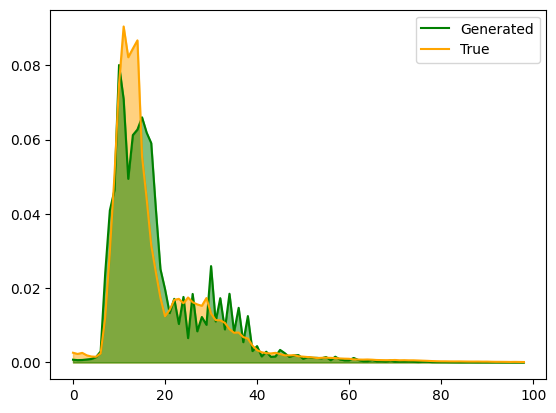

In [31]:
Eval.KLD_TrueGen(SecDataType ='FCIN',  AnalSig=AnalData[:]) 

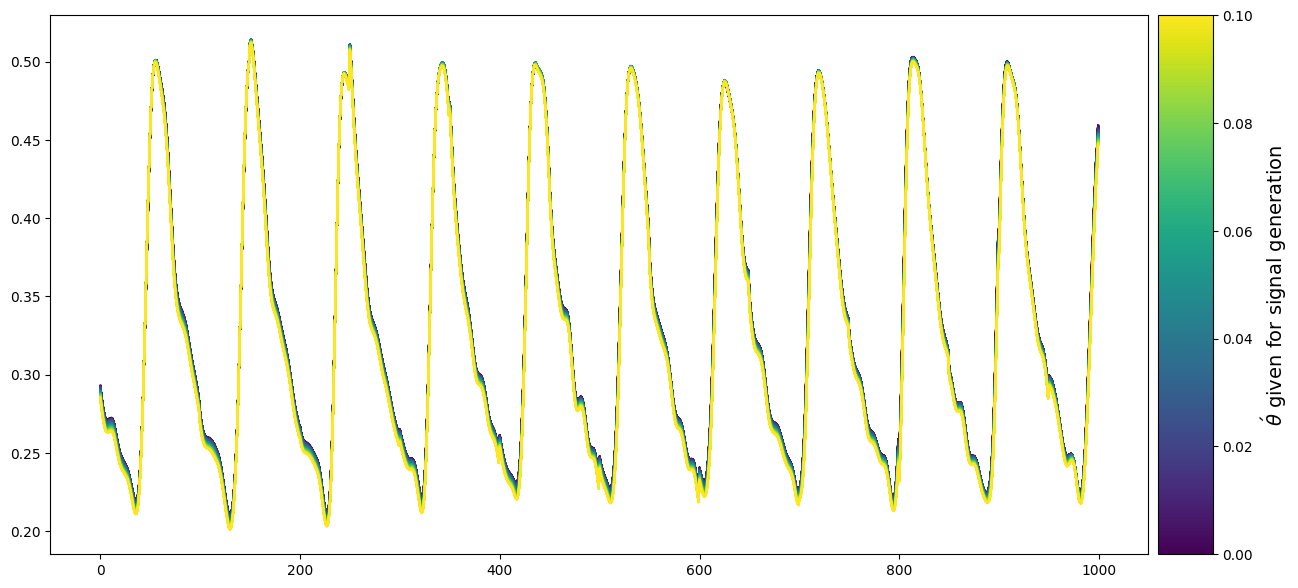

In [32]:
LatDim = 50
FreqID = 10
ZFixSubID =0
SelZ =  Eval.PostSamp[FreqID][ZFixSubID]['TrackZs']

assert ZFixSubID < len(Eval.PostSamp[FreqID]), 'ZFixSubID must be smaller than ' + str(len(Eval.PostSamp[FreqID]))

RecPred, HH,HL,LH, LL = VisReconGivenZ_FCA (FeatGenModel,  ReconModel, SelZ, Mode='Origin', N_Gen=300, MinFreqR=0.0, MaxFreqR=0.1)

In [245]:
Base = 0.2
UpLimit = 0.6
(UpLimit - Base)*np.random.rand(1) + Base

array([0.50366614])

In [246]:
LatDim = 50
FreqID = 10
ZFixSubID = 0
SelZ =  Eval.PostSamp[FreqID][ZFixSubID]['TrackZs']

assert ZFixSubID < len(Eval.PostSamp[FreqID]), 'ZFixSubID must be smaller than ' + str(len(Eval.PostSamp[FreqID]))

RecPred, HH,HL,LH, LL = VisReconGivenZ_FCA (FeatGenModel,  ReconModel, LatDim, SelZ, Mode='LL', N_Gen=1, MinFreqR=0.025, MaxFreqR=0.025)

TypeError: VisReconGivenZ_FCA() got multiple values for argument 'Mode'

In [98]:
HeatMapFreqZ_FCA (FeatGenModel,  ReconModel, LatDim, SelZ, N_Gen=300, MaxFreqR=0.05)

TypeError: HeatMapFreqZ_FCA() got multiple values for argument 'N_Gen'

In [20]:
def GenLowFilter (LF, N, Decay):
    nVec = np.arange(N, dtype=np.float32)
    Window = tf.signal.hamming_window(N)

    # A low-pass filter
    X = 2 * LF * (nVec - (N - 1) / 2)
    X = tf.where(X == 0, 1e-7, X)
    LPF = tf.sin(np.pi*X)/(np.pi*X)
    LPF *= Window
    LPF /= tf.reduce_sum(LPF, axis=-1, keepdims=True)
    
    # Freq cutoff Decay effect
    if Decay != 0:
        LPF *= tf.exp(-Decay * nVec) 
        #LPF *= tf.exp(-LF * Decay * nVec) 
        
    
    return LPF[:,None] 

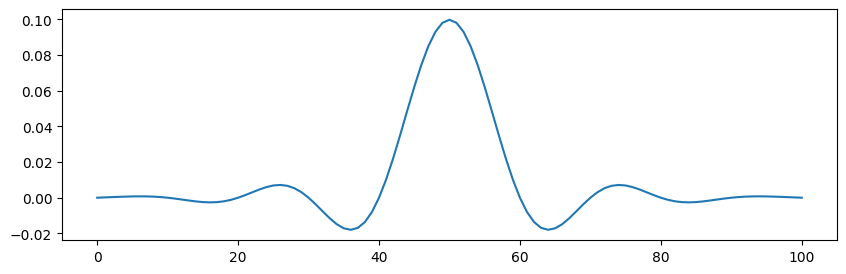

In [21]:
CompSize = 800
FiltLen = (1000 - CompSize)//2 + 1
Filter = GenLowFilter(0.05, FiltLen, 0)
plt.figure(figsize=(10, 3))
plt.plot(Filter[:, 0])

In [ ]:
plt.plot(Filter[:, 0])

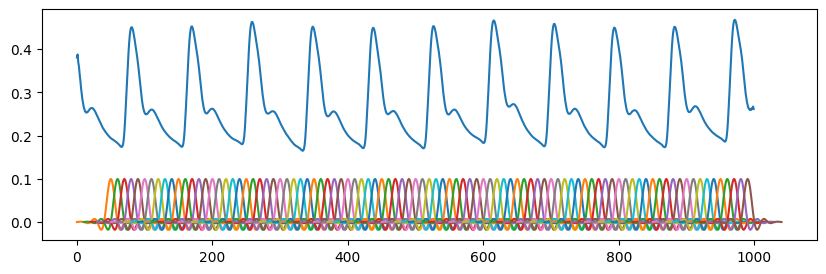

In [188]:
plt.figure(figsize=(10, 3))
plt.plot(np.arange(1000), AnalData[1])
for i in range (95):
    plt.plot(np.arange(10*i,101+10*i), Filter[:, 0])

1/1 [==============================] - 0s 36ms/step


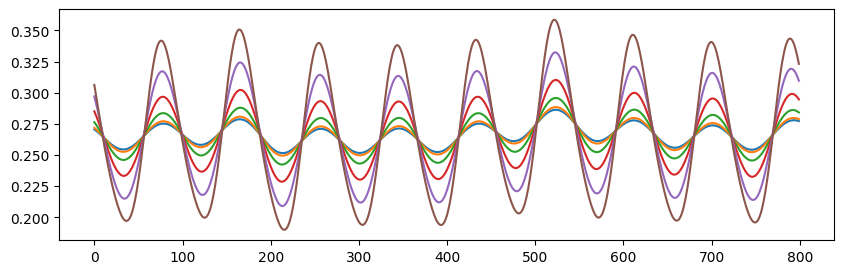

In [155]:
Freqs = np.tile(np.linspace(0, 0.02, 6)[:,None], (1, 6))
TmpData = np.tile(AnalData[1:2], (6, 1))    
PassData = FeatExtModel.predict([TmpData,Freqs])[3]

plt.figure(figsize=(10, 3))
for i, freq in zip(PassData, np.round(Freqs[:, 0], 3)):
    plt.plot(i, label = freq )
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

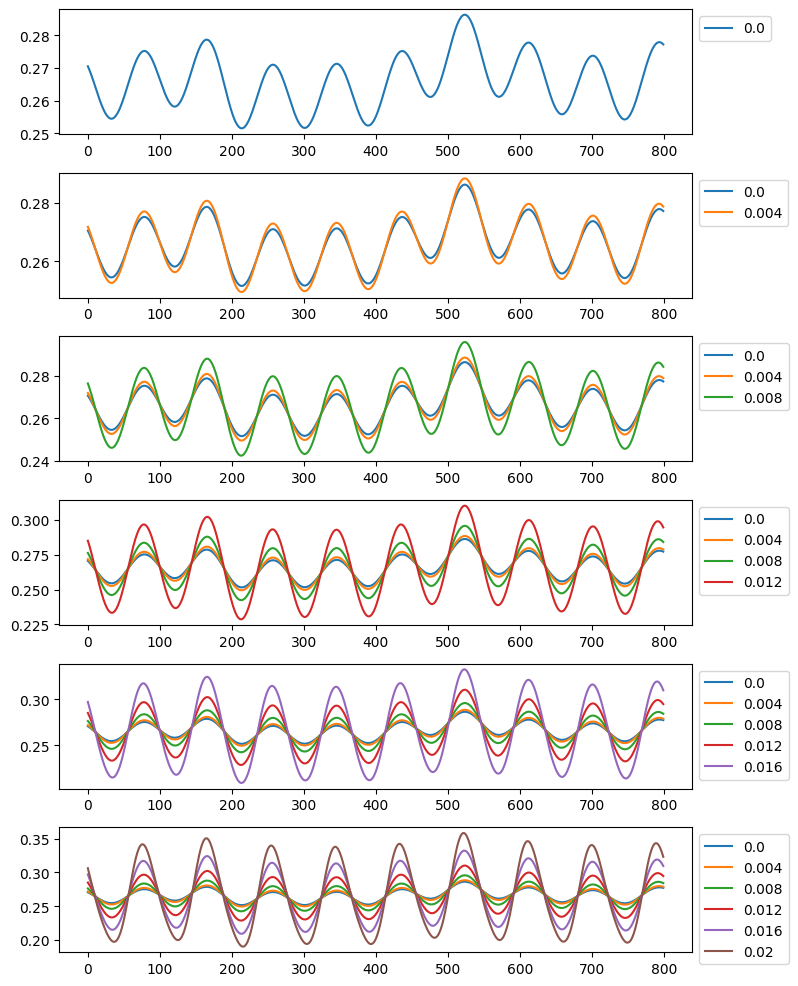

In [136]:
# Determine the number of subplots based on the length of PassData
num_subplots = len(PassData)

# Create a grid of subplots
fig, axes = plt.subplots(num_subplots, 1, figsize=(8, 10))

# Iterate over PassData and Freqs
for idx, (i, freq) in enumerate(zip(PassData, np.round(Freqs[:, 0], 3))):
    # For each iteration, plot results accumulated up to the current iteration
    for j in range(idx + 1):
        axes[idx].plot(PassData[j], label=np.round(Freqs[j, 0], 3))
    
    # Set legend for the current subplot
    axes[idx].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

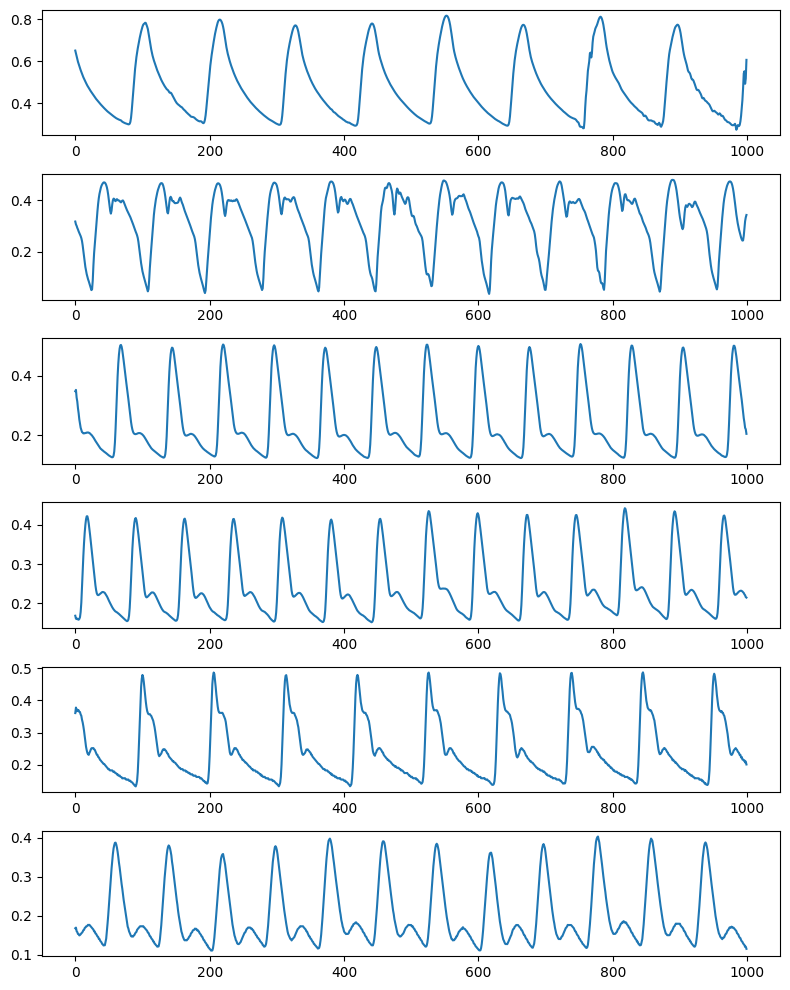

In [147]:
TmpData = np.random.permutation(AnalData)[:6]

# Determine the number of subplots based on the length of TmpData
num_subplots = len(TmpData)

# Create a grid of subplots
fig, axes = plt.subplots(num_subplots, 1, figsize=(8, 10))

# Iterate over TmpData
for idx, data in enumerate(TmpData):
    # Plot on the current subplot
    axes[idx].plot(data)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

1 0.0 0.03064586660295891
2 0.027581279942663017 0.05006583535909141
3 0.06988240377157899 0.051321844081751125
4 0.1090838230679971 0.03441369443260061
5 0.12914776575053796 0.006279051952931341
6 0.12188413593312239 -0.02185658206183039
7 0.09002479848416281 -0.03876770615968335
8 0.04613138309203152 -0.03751665432963618
9 0.007753255886155803 -0.018103624127275453
10 -0.009315331417007687 0.012533323356430412
11 0.0028961927454804527 0.04316829168308744
12 0.04145803598571111 0.06257538472683338
13 0.09363007864129004 0.06381654233424601
14 0.14170195887798245 0.04689156851215126
15 0.16973417465112034 0.018738131458572477
16 0.16962507549872355 -0.009418264563182935
17 0.14418612984198656 -0.02635211482255223
18 0.1060506135174909 -0.025125749719819533
19 0.07283237741790423 -0.005739362912251205
20 0.060383713055087725 0.02486898871648545
21 0.07672743159441586 0.055473413243613386
22 0.11898076035422632 0.07484801936649017
23 0.17444590174864485 0.07605475206175527
24 0.225450588

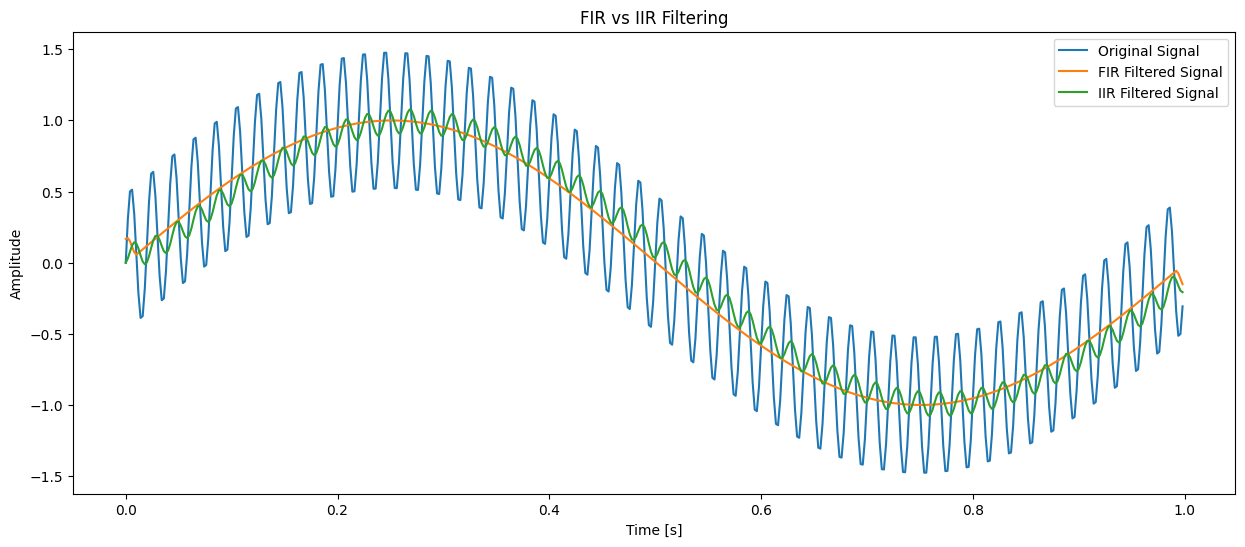

In [261]:
# 신호 생성: 1Hz의 신호와 50Hz의 노이즈를 포함
fs = 500  # 샘플링 주파수 500Hz
t = np.arange(0, 1, 1/fs)  # 1초 동안의 시간 배열
signal = np.sin(2 * np.pi * 1 * t) + 0.5 * np.sin(2 * np.pi * 50 * t)  # 신호 + 노이즈

# FIR 필터 설계: 간단한 이동 평균 필터
N = 10  # 필터의 탭 수
fir_filter = np.ones(N) / N

# FIR 필터 적용
fir_filtered = np.convolve(signal, fir_filter, mode='same')

# IIR 필터 설계 및 적용
iir_filtered = np.zeros_like(signal)
a = 0.9  # IIR 필터 계수 (반사계수)
for i in range(1, len(signal)):
    
    iir_filtered[i] = a * iir_filtered[i-1] + (1-a) * signal[i]
    print(i, a * iir_filtered[i-1] ,  (1-a) * signal[i])

# 결과 비교
plt.figure(figsize=(15, 6))
plt.plot(t, signal, label='Original Signal')
plt.plot(t, fir_filtered, label='FIR Filtered Signal')
plt.plot(t, iir_filtered, label='IIR Filtered Signal')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('FIR vs IIR Filtering')
plt.show()